In [2]:
## Sklearn practice, following along with Prof. Caraza-Harter plus some extra fun
## Original work can be found here: https://www.youtube.com/watch?v=0BG2BFvKDHo 
## Notes: After doing regression by hand (keyboard?), Sklearn is very friendly. I hate to admit my first attempt used for loops. Really well optimized for loops imo, but for loops nonetheless.
## Author: Conrad Wiebe

In [3]:
import numpy as np
from pandas import DataFrame
# import dask.dataframe as dd # Not needed :( I wanna learn dask so bad

### Step 0: Create data

In practice, cleaning the data is often the longest part of the process. As this is just practice, we get to ignore all that and jump straight into the fun.

In [4]:
# Data knobs, don't judge I was playing around
n=2000
density = 5

bound = (n/(2*density))**.5 / 2
xbounds = (-bound,bound)
ybounds = (-bound,bound)

# Generate data
df = DataFrame({
    'x':np.random.uniform(xbounds[0], xbounds[1],n),
    'y':np.random.uniform(ybounds[0],ybounds[1],n)
    })
df['color'] = 'lightgray' # Start with all points as one class

# Add noisy circle boundary, scales to stay around 20% of our data regardless of density
center = (np.random.uniform(xbounds[0]/3,xbounds[1]/2), np.random.uniform(ybounds[0]/2,ybounds[1]/3))
radius = bound / 2
dist = ((df['x']-center[0])**2+(df['y']-center[1])**2)**.5
df.loc[dist < radius + np.random.normal(size=n)/bound, 'color'] = 'black'

# Add a static noisy circle inside the other
radius = 1
dist = ((df['x']-center[0])**2+(df['y']-center[1])**2)**.5
df.loc[dist < radius + np.random.normal(size=n)/bound, 'color'] = 'red'

# Peep our data
print(df[['color']].value_counts().to_frame(name='counts'))
df.head()


           counts
color            
lightgray    1627
black         339
red            34


,x,y,color
0,-3.003217,1.859848,lightgray
1,4.531474,-5.074994,lightgray
2,0.370674,-6.315334,lightgray
3,0.653319,-1.473602,black
4,-4.258198,-3.212079,lightgray


<AxesSubplot:xlabel='x', ylabel='y'>

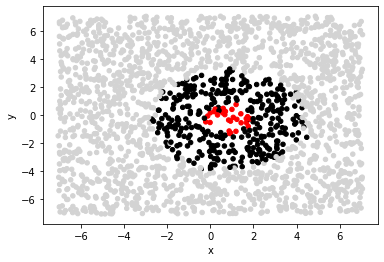

In [5]:
# Peep our data
df.plot.scatter('x','y', c=df['color'])

-------------------------------------------------------------

### Step 1: Build model

In [6]:
from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [7]:
train, test = train_test_split(df, train_size = .75)
train.shape, test.shape

((1500, 3), (500, 3))

In [8]:
lr = LogisticRegression()
lr.fit(train[['x', 'y']], train[['color']])
lr.classes_

array(['black', 'lightgray', 'red'], dtype=object)

---------------------------------------
### Step 2: Evaluate model

In [9]:
train_acc = lr.score(train[['x', 'y']], train[['color']])
test_acc = lr.score(test[['x', 'y']], test[['color']])
print(f'Model has a training accuracy of {train_acc*100:.2f}% and a testing accuracy of {test_acc*100:.2f}%')

Model has a training accuracy of 80.67% and a testing accuracy of 83.40%


Looks good right? Lets compare that now to what a naive guesser would do... 

If you are wondering why we would look at both the training set and testing set accuracy, in some situations you may find your training accuracy to be much higher than the testing, which is a strong indication that your model has overfitted the data.



In [10]:
class_weights = df['color'].value_counts() / len(df)
print(class_weights.to_frame(name='%'))

                %
lightgray  0.8135
black      0.1695
red        0.0170


Here we see that our classes are far from equally represented

A naive guesser can guess the lightgray class for every point and still have ~90% accuracy!

Unfortunately, that looks to be exactly what our model is doing

-----
### Step 2.5: Visualize the model

This gets increasingly difficult as more dimensions are included in our data. In this case, we are working with 2D data and as such we (as humans) are still able to draw meaningful conclusions from visualizing what is going on.

Why is this a half step? Visualizing the model is really just another way of evaluating its performance. It allows us to get a feel for what the model is actually doing.

In [11]:
# Add a new column to our data, the predicted color
ptrain, ptest = train.copy(), test.copy()
ptrain['predicted_color'] = lr.predict(train[['x','y']])
ptest['predicted_color'] = lr.predict(test[['x','y']])
ptest.head()

,x,y,color,predicted_color
987,0.297212,1.521882,black,lightgray
927,-2.491991,5.005707,lightgray,lightgray
1676,-1.539941,4.468779,lightgray,lightgray
1877,0.332476,-0.004829,red,lightgray
1217,3.989281,-1.785231,black,lightgray


The simplest visualization we use will be a confusion matrix.

A confusion matrix shows us the labels our model is predicting vs the actual labels in a concise way. In this example, we see that the model has a much harder time predicting dogs than cats.
<p>
<table>

<tbody><tr>
<td>
<table class="wikitable" style="border:none; float:left; margin-top:0; text-align:center;">
<tbody><tr>
<th style="background:none; border:none;" colspan="2" rowspan="2">
</th>
<th colspan="2" style="background:none;">Actual class
</th></tr>
<tr>
<th>Cat
</th>
<th>Dog
</th></tr>
<tr>
<th rowspan="2" style="height:6em;background:none;"><div>Predicted<br />class</div>
</th>
<th>Cat
</th>
<td><b>5</b>
</td>
<td>2
</td></tr>
<tr>
<th>Dog
</th>
<td>3
</td>
<td><b>3</b>
</td></tr>
</tbody></table>
</td>
<td>
</td></tr></tbody></table>
</p>

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>


<p>
Cat and Dog example taken from https://en.wikipedia.org/wiki/Confusion_matrix
</p>


In [12]:
labels = np.unique(df[['color']].values)
labels

array(['black', 'lightgray', 'red'], dtype=object)

In [13]:
DataFrame(confusion_matrix(ptest[['color']], ptest[['predicted_color']], labels=labels), index=labels, columns=labels).T

,black,lightgray,red
black,0,0,0
lightgray,76,417,7
red,0,0,0


Yikes! It looks like our model is predicting every single point as lightgray. Lets plot the data and our predictions to get a better look

In [14]:
def visualize(train, test):
    _, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ptrain.plot.scatter('x','y', c=ptrain['color'], ax = axs[0][0], title='Real class labels [Training]')
    ptrain.plot.scatter('x','y', c=ptrain['predicted_color'], ax = axs[0][1], title='Predicted class labels [Training]')
    ptest.plot.scatter('x','y', c=ptest['color'], ax = axs[1][0], title='Real class labels [Testing]')
    ptest.plot.scatter('x','y', c=ptest['predicted_color'], ax = axs[1][1], title='Predicted class labels [Testing]')
    return axs

array([[<AxesSubplot:title={'center':'Real class labels [Training]'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Predicted class labels [Training]'}, xlabel='x', ylabel='y'>],
       [<AxesSubplot:title={'center':'Real class labels [Testing]'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Predicted class labels [Testing]'}, xlabel='x', ylabel='y'>]],
      dtype=object)

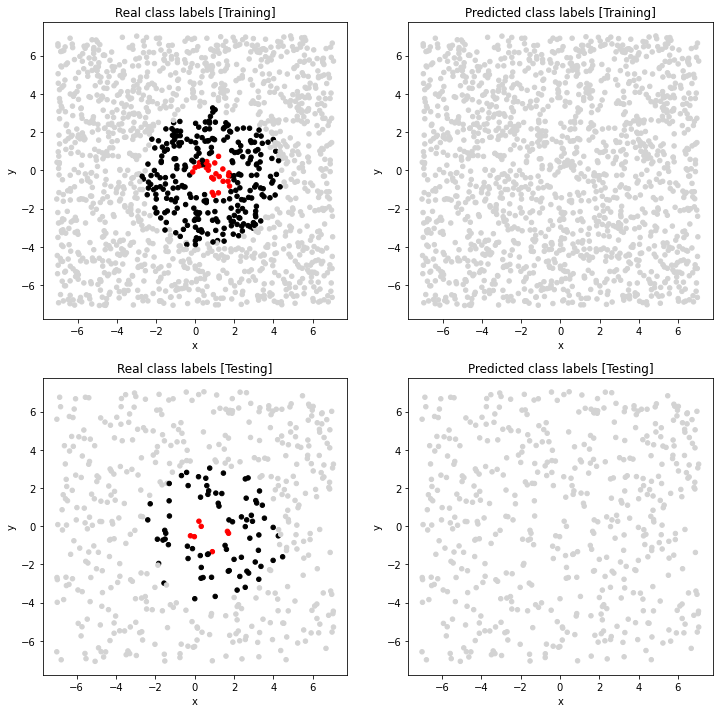

In [15]:
import matplotlib.pyplot as plt
visualize(ptrain, ptest)

### Why does this happen?

Our model can only reprent linear relationships right now, and it learned that the best linear representation was a line that classified all features as 'lightgray', apparently any attempt at dividing the data space would lower its accuracy. This is randomly generated, so it is possible that for your run it found a line that would increase accuracy as opposed to simply guessing all light gray.

### How can we fix* this?

One thing we can do is give our model more input features to play with. If we give the model non-linear representations of our data, it can form a linear representation on top.

\* fix is a strong word. 

-------------------------------------------------------------
### Step 3: Rebuild the model

In [16]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

In [17]:
pf = PolynomialFeatures(include_bias=False) # False as everything in Sklearn wants to add an intercept for us
DataFrame(pf.fit_transform(train[['x', 'y']]), 
            columns=pf.get_feature_names(['x','y'])).head()

,x,y,x^2,x y,y^2
0,-6.375290,-5.009377,40.644319,31.936227,25.093854
1,-2.664478,-6.818092,7.099444,18.166658,46.486381
2,-5.224327,-2.231884,27.293594,11.660089,4.981304
3,-6.962732,0.746052,48.479641,-5.194562,0.556594
4,4.655892,0.351470,21.677331,1.636404,0.123531


But how to add features without needing to alter our train data, test data, and any novel data we want to predict on?

We build a Pipeline! A Pipeline can be treated like a regular model, it has all the methods we care about, but it can consist of any number of steps. Cleaning data, adding features, and doing the precition itself.

In [18]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(include_bias=False), LogisticRegression())
pipe.fit(train[['x','y']], train[['color']])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('logisticregression', LogisticRegression())])

--------------------------------------
### Step 4: Evaluate the model

If we evaluate the model we should find that it is a better predictor than before

In [19]:
train_acc = pipe.score(train[['x', 'y']], train[['color']])
test_acc = pipe.score(test[['x', 'y']], test[['color']])
print(f'Model has a training accuracy of {train_acc*100:.2f}% and a testing accuracy of {test_acc*100:.2f}%')

Model has a training accuracy of 96.93% and a testing accuracy of 97.20%


--------
### Step 4.5: Visualize the model

If we visualize the predictions, we should see that this time around, we are much closer to representing the real distribution of our data

In [20]:
ptrain['predicted_color'] = pipe.predict(train[['x','y']])
ptest['predicted_color'] = pipe.predict(test[['x','y']])

In [21]:
# Uncomment for confusion matrix, the plot shows the same information about our model
# DataFrame(confusion_matrix(ptest[['color']], ptest[['predicted_color']], labels=labels), index=labels, columns=labels).T

array([[<AxesSubplot:title={'center':'Real class labels [Training]'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Predicted class labels [Training]'}, xlabel='x', ylabel='y'>],
       [<AxesSubplot:title={'center':'Real class labels [Testing]'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Predicted class labels [Testing]'}, xlabel='x', ylabel='y'>]],
      dtype=object)

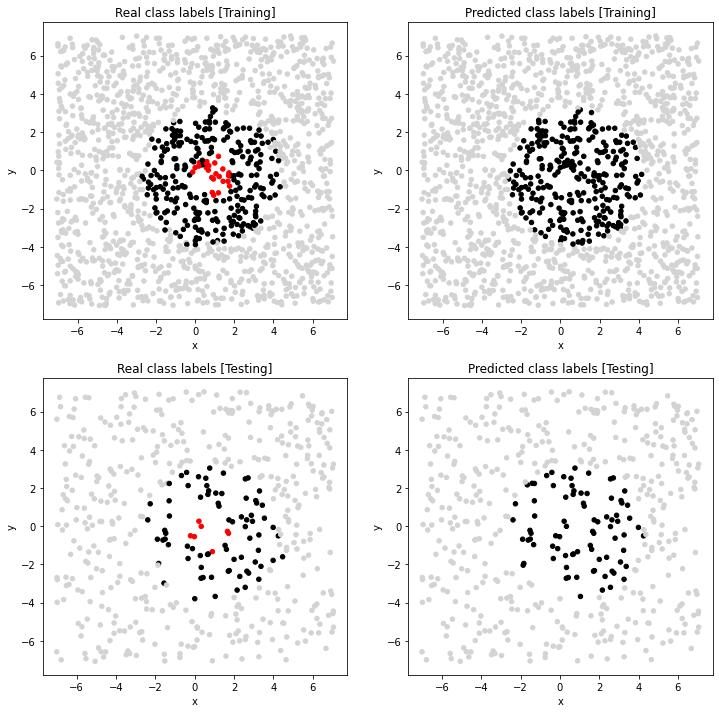

In [22]:
visualize(ptrain, ptest)

It already looks much better than before, but it is still unable to differentiate between the two concentric circles. Instead, it classifies them according to whichever color circle has more of the data.

--------
### Step 5: Re-Build the model

We were able to classify the black points very well, but it doesn't seem like that simple of a pipline will be able to fit the concentric circles in our data. Perhaps a simple neural network would suffice? Here we use a tiny network, two layers and 5 neurons total.

In [23]:
from sklearn.neural_network import MLPClassifier

In [24]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(include_bias=False), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1))
pipe.fit(train[['x','y']], train[['color']])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3, 2),
                               random_state=1, solver='lbfgs'))])

--------------------------------------
### Step 6: Evaluate the model


In [25]:
train_acc = pipe.score(train[['x', 'y']], train[['color']])
test_acc = pipe.score(test[['x', 'y']], test[['color']])
print(f'Model has a training accuracy of {train_acc*100:.2f}% and a testing accuracy of {test_acc*100:.2f}%')

Model has a training accuracy of 98.53% and a testing accuracy of 98.60%


--------------------------------------
### Step 6.5: Visualize the model

In [26]:
ptrain['predicted_color'] = pipe.predict(train[['x','y']])
ptest['predicted_color'] = pipe.predict(test[['x','y']])

In [27]:
# DataFrame(confusion_matrix(ptest[['color']], ptest[['predicted_color']], labels=labels), index=labels, columns=labels).T

array([[<AxesSubplot:title={'center':'Real class labels [Training]'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Predicted class labels [Training]'}, xlabel='x', ylabel='y'>],
       [<AxesSubplot:title={'center':'Real class labels [Testing]'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Predicted class labels [Testing]'}, xlabel='x', ylabel='y'>]],
      dtype=object)

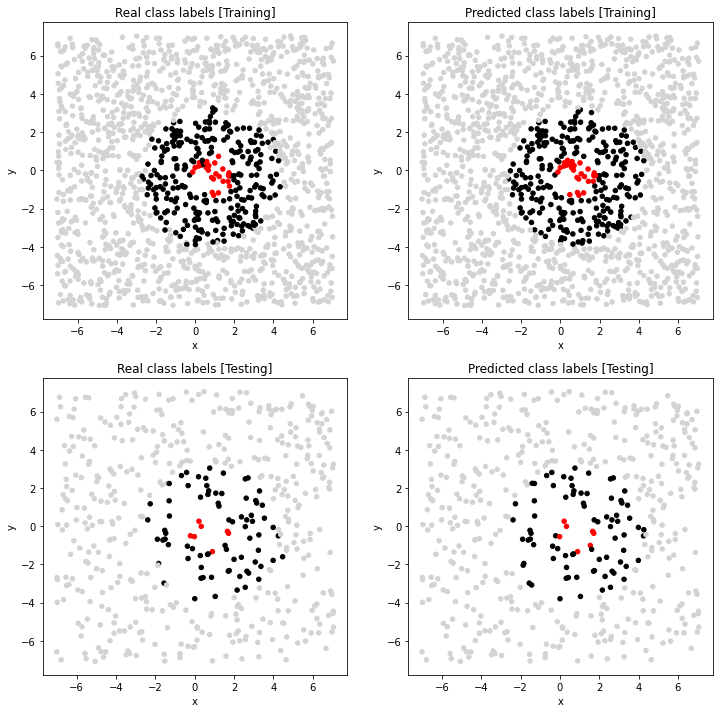

In [28]:
visualize(ptrain, ptest)

--------
### Conclusion

As you can tell, creating an accurate model is something of a recursive process. There is no cut and dry endpoint, rather we build and rebuild until the desired performance is reached, or our bosses lose patience. A big part of ML is rapid iterations, as Mark Zuckerberg said, "Move fast and break things". It is important to find a pipeline (not the Sklearn one!) that allows you to rapidly build and test a model.

In this mini we did not ever deal with over-fitting, which is another problem that forces us to rethink the way our model is designed, although it becomes much more of a problem in deeper models. 

I encourage you to add some more classes to the data. Here you can see that the 'red' class has hardly any values, this makes it very hard to predict. Maybe try giving red even less values, can the model still fit it?

Lastly, would our model benefit from having more polynomial features? For the last model, would more neurons be of any benefit? Why or why not?